## CHEME 5660: Using Single Index Models in Markowitz Portfolio Allocations

### Introduction
The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of __only__ risky assets is the [quadratic program](https://en.wikipedia.org/wiki/Quadratic_programming):

$$\min_{w} \sigma^{2}_{\mathcal{P}}\left(w\right)$$

subject to the constraints:

$$
\begin{eqnarray}
\mathbb{E}(r_{\mathcal{P}})&\geq&{R^{*}}\\
1^{T}w &=& 1\\
w_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray}
$$

where $w$ denotes the vector of weights of the assets in portfolio $\mathcal{P}$, $\sigma^{2}_{\mathcal{P}}\left(w\right)$ represents the portfolio variance; the portfolio variance can re-written as $\sigma^{2}_{\mathcal{P}}\left(w\right) = w^{T}\Sigma{w}$  where $\Sigma$ is the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix). The quantity $\mathbb{E}(r_{\mathcal{P}})$ denotes the expected return (or excess return) of the portfolio $\mathcal{P}$; the expected return (or excess return) can be re-written as $w^{T}\mathbb{E}(r)$ where $\mathbb{E}(r)$ denotes the vector of expected returns (or excess returns) for each asset in the portfolio. 

The quantity $R^{*}$ denotes the minimal required return for $\mathcal{P}$, and $1^{T}$ represents a vector of ones (total allocation constraint). The last constraint $w_{i}\geq{0}~\forall{i}\in\mathcal{P}$ says that no short selling (borrowing shares) is allowed; if short selling is allowed, then this constraint can be removed.

#### Risk-free case
If we include risk-free assets in the portfolio, then the reward constraint is replaced by:

$$\left(1-\sum_{a\in\mathcal{A}}\omega_{a}\right)r_{f}+\mathbb{E}(r_{\mathcal{P}})\geq{R^{*}}$$

where $r_{f}$ denotes the risk-free rate of return.

#### Single index models
We can use Single Index Models (SIMs) to compute the expected return and the covariance based upon the relationship between firm $i$ and a market index, e.g., the SP500.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using CSV
using Dates
using Colors
using Plots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

### Load the example code library
The call to the `include` function loads the `Example-Markowitz-CodeLib.jl` library into the notebook; the library contains types and functions we use during the lab:

__Functions__:
* `compute_minvar_portfolio_allocation --> Tuple` and `compute_minvar_portfolio_allocation_risk_free --> Tuple` compute the optimum (minimum) risk given a specified reward for risky and risky+risk-free portfolios. 
* `compute_fractional_return_array --> DataFrame` computes the fractional return for a firm $i$
* `compute_covariance_array --> Array{Float64,2}` computes the covariance matrix $\Sigma$ from the return values.

In [3]:
include("Example-SIM-Markowitz-CodeLib.jl");

In [4]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# how many days of historical data are we using?
m = 200;

### a) Load the historical data set
The historical data set was downloaded using the [RESTful Application Programming Interface of Polygon.io](https://polygon.io) using the [PQPolygonSDK.jl](https://github.com/Paliquant/PQPolygonSDK.jl) package. The data contains daily Open High Low Close (OHLC) data for N = 100 stocks for the last two-years.

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [6]:
# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many tickers do we have?
Nₐ = length(ticker_symbol_array);

### b) Estimate SIMs for each asset in our collection

#### Phase 1: Estimate $\left(\alpha_{i}, \beta_{i}\right)$ usind direct matrix inversion

In [7]:
# initialize -
sim_model_dictionary = Dict{String, SingleIndexModel}();

# compute the excess nreturn for SPY (which is in the data set)
Rₘ = compute_excess_return(price_data_dictionary["SPY"]; rf = risk_free_daily, m = m);

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # compute the excess return for asset_ticker -
    Rᵢ = compute_excess_return(price_data_dictionary[asset_ticker], rf = risk_free_daily, m = m);
    
    # formulate the Y and X arrays with the price data -
    max_length = length(Rᵢ);
    Y = Rᵢ;
    X = [ones(max_length) Rₘ];
    
    # compute θ -
    θ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = SingleIndexModel();
    sim_model.α = θ[1];
    sim_model.β = θ[2];
    sim_model.r = risk_free_daily;
    sim_model_dictionary[asset_ticker] = sim_model;
end

In [22]:
sim_model_dictionary["AMD"]

SingleIndexModel(0.2685113150954087, 2.0318463513736638, 0.00010825005887427075, Normal{Float64}(μ=2.4424906541753444e-17, σ=2.3700451715958355))

#### Phase 2: Estimate the error models $\epsilon\left(t\right)$

In [9]:
# compute the error model -

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker (data) -
    Rᵢ = compute_excess_return(price_data_dictionary[asset_ticker]; rf = risk_free_daily, m = m);
    
    # what is the length -
    max_length = length(Rᵢ);
    
    # compute the model excess return -
    αᵢ = sim_model.α
    βᵢ = sim_model.β
    R̂ᵢ = αᵢ .+ βᵢ .* Rₘ
    
    # compute the residual -
    Δ = Rᵢ .- R̂ᵢ;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Δ);
    
    # update the sim_model -
    sim_model.ϵ = d;
end

##### Visualize SIM performance

In [23]:
# pick an asset -
asset_ticker = "AMD"
sim_model = sim_model_dictionary[asset_ticker];

# compute the excess return for asset_ticker (data) -
Rᵢ = compute_excess_return(price_data_dictionary[asset_ticker]; rf = risk_free_daily, m = m);

# evaluate the SIM (without noise) -
R̂ᵢ = evaluate_model(sim_model, sort(Rₘ));

# sample the SIM to get the uncertainty region -
R̂ᵢ_samples = sample_sim_model(sim_model, sort(Rₘ); 𝒫 = 1000);

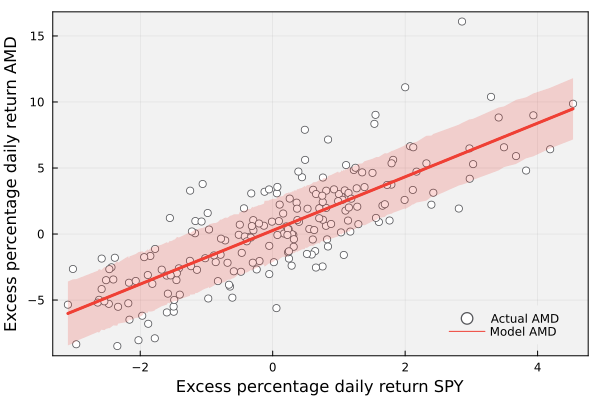

In [24]:
# data and expected value -
scatter(Rₘ, Rᵢ, mc=colorant"#FFFFFF", msc=colorant"#55565A", label="Actual $(asset_ticker)", legend=:bottomright)

# uncertainty region -
L = R̂ᵢ .- std(R̂ᵢ_samples,dims=2)
U = R̂ᵢ .+ std(R̂ᵢ_samples,dims=2)

plot!(sort(Rₘ), R̂ᵢ, fillrange=U, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")
plot!(sort(Rₘ), R̂ᵢ, fillrange=L, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")

plot!(sort(Rₘ), R̂ᵢ, lw=3, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="Model $(asset_ticker)")


# labels -
xlabel!("Excess percentage daily return SPY",fontsize=18)
ylabel!("Excess percentage daily return $(asset_ticker)",fontsize=18)

# uncomment me to save figure to disk -
#filename = "Fig-SIM-$(asset_ticker)-m-200-11-3-2022.pdf";
#savefig(joinpath(_PATH_TO_FIGS, filename));

### c) Markowitz Allocation using Single Index Models of Risk and Return

In [12]:
# compute the μ_vector -
μ_vector = μ(sim_model_dictionary, Rₘ, ticker_symbol_array);

In [13]:
# compute Σ -
Σ_array = Σ(sim_model_dictionary, Rₘ, ticker_symbol_array);

In [14]:
# define the returns that we are going to simulate -
target_return_array = 100 .*range(0.0, step=0.0001, stop = 0.004) |> collect # percentage
L = length(target_return_array)

# Initialize MinVar array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarArray = Array{Float64,2}(undef,L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation(μ_vector, Σ_array, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        MinVarArray[i,1] = opt_val;
        MinVarArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarArray[i,2+a] = ω[a]
        end
    end
end

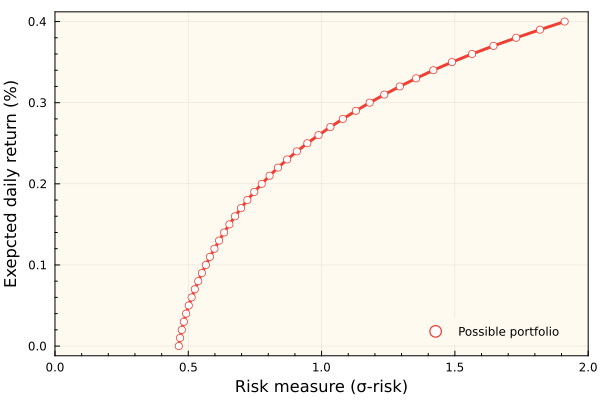

In [15]:
# pull out the risk and rerturn -
risk_array = sqrt.(MinVarArray[:,1])
return_array = MinVarArray[:,2];

# plot -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, xlim=(0.0,2.0),minorticks=0.1)
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted daily return (%)", fontsize=18)

In [26]:
# make a allocation table for risky asset *only* case -

# what portfolio index do we need?
portfolio_index = 41;
δ = 0.01; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small = findall(x-> abs(x) >= δ, MinVarArray[portfolio_index,3:end])
A = length(idx_not_small);

# setup table -
allocation_table_data = Array{Any,2}(undef, A+1, 4);
for a ∈ 1:A
    
    # grab the data -
    idx = idx_not_small[a];
    ticker = ticker_symbol_array[idx]
    ωₐ = MinVarArray[portfolio_index,(idx .+ 2)];

    # package -
    allocation_table_data[a,1] = ticker;
    allocation_table_data[a,2] = ωₐ
    allocation_table_data[a,3] = μ_vector[idx];
    allocation_table_data[a,4] = Σ_array[idx,idx];
end

w_tmp  = MinVarArray[portfolio_index, 3:end];

# add a total row -
allocation_table_data[end,1] = "Total"
allocation_table_data[end,2] = sum(allocation_table_data[1:A,2])
allocation_table_data[end,3] = MinVarArray[portfolio_index,2];
allocation_table_data[end,4] = sqrt.(MinVarArray[portfolio_index,1])

# header -
allocation_table_header = (["Ticker", "weight", "E(r)", "var"])

# show the table -
pretty_table(allocation_table_data; header = allocation_table_header)

┌────────┬───────────┬───────────┬─────────┐
│ Ticker │    weight │      E(r) │     var │
├────────┼───────────┼───────────┼─────────┤
│    AMD │  0.115237 │  0.465808 │ 15.8122 │
│    BIO │ 0.0868602 │  0.342851 │ 7.02652 │
│   INTC │  0.102001 │  0.345549 │ 6.11639 │
│   NFLX │ 0.0255769 │  0.424057 │ 31.4018 │
│    SWK │   0.55268 │  0.477961 │ 7.86696 │
│    VXX │  0.117642 │ 0.0534446 │ 14.3926 │
│  Total │  0.999997 │       0.4 │ 1.91168 │
└────────┴───────────┴───────────┴─────────┘


### d) Markowitz Allocation using Single Index Models of Risk and Return (risky+risk-free)

In [17]:
# Initialize MinVarRiskFree array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarRiskFreeArray = Array{Float64,2}(undef, L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation_risk_free(μ_vector, Σ_array, tr;
        risk_free_return = risk_free_daily, w_lower =  0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        # capture the risk and reward values -
        MinVarRiskFreeArray[i,1] = opt_val;
        MinVarRiskFreeArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarRiskFreeArray[i,2+a] = ω[a]
        end
    end
end

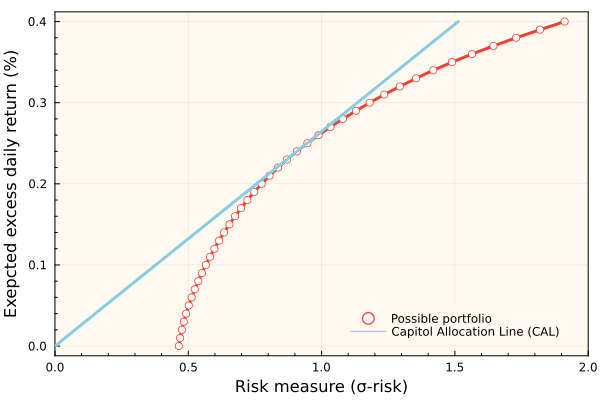

In [18]:
# pull out the risk and rerturn for the risk-free case -
risk_array_rf = sqrt.(MinVarRiskFreeArray[:,1])
return_array_rf = MinVarRiskFreeArray[:,2];

# plot the risk-only portfolio -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, minorticks=0.1, xlim=(0.0,2.0))
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")

# plot the CAL -

plot!(risk_array_rf,  return_array_rf, lw=3, c=colorant"#89CCE2", label="Capitol Allocation Line (CAL)")

# axis labels -
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted excess daily return (%)", fontsize=18)

In [27]:
# make a allocation table for risky+risk free asset case -

# what portfolio index do we need?
portfolio_index_rf = findall(x->x<=1.40, risk_array_rf)[end]
δ = 0.005; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small_rf = findall(x-> abs(x) >= δ, MinVarRiskFreeArray[portfolio_index_rf,3:end])
A = length(idx_not_small_rf);

# setup table -
allocation_table_data_rf = Array{Any,2}(undef, A+1, 4);
for a ∈ 1:A
    
    # grab the data -
    idx = idx_not_small_rf[a];
    ticker = ticker_symbol_array[idx]
    ωₐ = MinVarRiskFreeArray[portfolio_index,(idx .+ 2)];

    # package -
    allocation_table_data_rf[a,1] = ticker;
    allocation_table_data_rf[a,2] = ωₐ
    allocation_table_data_rf[a,3] = μ_vector[idx];
    allocation_table_data_rf[a,4] = Σ_array[idx,idx];
end

# add a total row -
allocation_table_data_rf[end,1] = "Total"
allocation_table_data_rf[end,2] = sum(MinVarRiskFreeArray[portfolio_index_rf, (idx_not_small_rf .+ 2)])
allocation_table_data_rf[end,3] = MinVarRiskFreeArray[portfolio_index_rf,2];
allocation_table_data_rf[end,4] = sqrt.(MinVarRiskFreeArray[portfolio_index_rf,1])

# header -
allocation_table_header_rf = (["Ticker", "weight", "E(r)", "σ"])

# show the table -
pretty_table(allocation_table_data_rf; header = allocation_table_header_rf)

┌────────┬────────────┬───────────┬─────────┐
│ Ticker │     weight │      E(r) │       σ │
├────────┼────────────┼───────────┼─────────┤
│   ALLY │  0.0352252 │  0.335356 │ 8.30703 │
│    BIO │   0.129959 │  0.342851 │ 7.02652 │
│    CLX │  0.0224564 │  0.116683 │ 5.06558 │
│      F │  0.0201082 │  0.345841 │ 10.1355 │
│    FDX │  0.0244715 │  0.267445 │ 9.25132 │
│   INTC │   0.166425 │  0.345549 │ 6.11639 │
│    MMM │   0.059844 │  0.180231 │ 3.35093 │
│   NFLX │ 0.00971344 │  0.424057 │ 31.4018 │
│    SWK │   0.264938 │  0.477961 │ 7.86696 │
│      T │  0.0661657 │  0.195531 │  5.7532 │
│    VWO │    0.20604 │  0.181731 │ 2.02123 │
│    VXX │   0.335146 │ 0.0534446 │ 14.3926 │
│     VZ │   0.263895 │  0.175631 │ 2.29894 │
│    WBA │  0.0627925 │  0.202028 │ 3.82053 │
│  Total │    1.54187 │  0.369993 │ 1.39903 │
└────────┴────────────┴───────────┴─────────┘


### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.